# SI 630: Homework 2 Parts 1-3: Word2Vec

This homework will have you implementing word2vec using PyTorch and let you familiarize yourself with building more complex neural networks and the larger PyTorch development infrastructure.

Broadly, this homework consists of a few major parts:
1. Implement a `Corpus` class that will load the dataset and convert it to a sequence of token ids
2. Implement negative sampling to select tokens to be used as negative examples of words in the context
3. Create your dataset of positive and negative examples per context and load it into PyTorch's `DataLoader` to use for sampling
4. Implement a `Word2Vec` class that is a PyTorch neural network
5. Implement a training loop that samples a _batch_ of target words and their respective positive/negative context words
6. Implement rare word removal and frequent word subsampling
7. Run your model on the full dataset for at least one epoch
8. Do the exploratory parts of the homework
9. Save vectors and word-indexing data for later use in training a classifier

After Step 5, you should be able to run your word2vec implementation on a small dataset and verify that it's learning correctly. Once you can verify everything is working, proceed with steps 6 and beyond. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**

### Estimated performance times

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading and tokenizing: ~5 seconds
* Subsampling and converting to token ids: ~15 seconds
* Generating the list of training examples: ~15 minutes
* Training one epoch: ~12 minutes

A quick note: the code that generates training instances is probably slower than it needs to be based on how we've described the process. The instructions make generating training tuples conceptually easier by breaking it into steps. _However_, the steps introduce a subtle performance bug from sampling random numbers one at a time when we really need a lot of them (particularly for the negative samples). Fixing this performance but will cause the training data to be generated in ~20% of the time but makes the code a bit ugly to read. Since you only need to generate the training instances once (and could even save these to disk if needed) we've kept the instructions as is. However, if you decide to scale up to the bigger corpora, you might dig into the cell that calls `generate_negative_samples`. 

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from tqdm import tqdm
from tqdm.auto import trange
from collections import Counter
import random
from torch import optim

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# Helpful for computing cosine similarity--Note that this is NOT a similarity!
from scipy.spatial.distance import cosine

# Handy command-line argument parsing
import argparse

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# We'll use this to save our models
from gensim.models import KeyedVectors

import re

import pickle

#
# IMPORTANT NOTE: Always set your random seeds when dealing with stochastic
# algorithms as it lets your bugs be reproducible and (more importantly) it lets
# your results be reproducible by others.
#
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)

## Create a class to hold the data

Before we get to training word2vec, we'll need to process the corpus into some representation. The `Corpus` class will handle much of the functionality for corpus reading and keeping track of which word types belong to which ids. The `Corpus` class will also handle the crucial functionality of generating negative samples for training (i.e., randomly-sampled words that were not in the target word's context).

Some parts of this class can be completed after you've gotten word2vec up and running, so see the notes below and the details in the homework PDF.

In [2]:
class Corpus:
    
    def __init__(self):

        self.tokenizer = RegexpTokenizer(r'\w+')
        
        # These state variables become populated with function calls
        #
        # 1. load_data()
        # 2. generate_negative_sampling_table()
        #
        # See those functions for how the various values get filled in

        self.word_to_index = {} # word to unique-id
        self.index_to_word = {} # unique-id to word

        # How many times each word occurs in our data after filtering
        self.word_counts = Counter()

        # A utility data structure that lets us quickly sample "negative"
        # instances in a context. This table contains unique-ids
        self.negative_sampling_table = []
        
        # The dataset we'll use for training, as a sequence of unqiue word
        # ids. This is the sequence across all documents after tokens have been
        # randomly subsampled by the word2vec preprocessing step
        self.full_token_sequence_as_ids = None
        
        self.first = []
        
        self.pwi_list = []
        
    def tokenize(self, text):
        '''
        Tokenize the document and returns a list of the tokens
        '''
        return self.tokenizer.tokenize(text)        

    def load_data(self, file_name, min_token_freq):
        '''
        Reads the data from the specified file as long long sequence of text
        (ignoring line breaks) and populates the data structures of this
        word2vec object.
        '''

        # Step 1: Read in the file and create a long sequence of tokens for
        # all tokens in the file
        
        with open(file_name) as file:
            txt = file.read()
        
        txt = txt.lower()
        
        first = self.tokenize(txt)
        all_tokens = [*set(first)]
        print('Reading data and tokenizing')
    
        # Step 2: Count how many tokens we have of each type
        print('Counting token frequencies')
        
        stop_words = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','this','will','and','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','a','an','the','of','at','was','that','to','m','so','from','very','with','as']
        
        stop_num = 0
        
        for i in range(len(first)):
            if first[i] in stop_words:
                first[i] = "<STOP>"
                stop_num = stop_num + 1
                
        counter = Counter(first)
        
        # Step 3: Replace all tokens below the specified frequency with an <UNK>
        # token. 
        #
        
        new_token = list(counter.keys())

        not_low_fre_word = []
        
        for i in range(len(new_token)):
            if counter[new_token[i]] < min_token_freq:
                new_token[i] = "<UNK>"
            else:
                not_low_fre_word.append(new_token[i])
                
        
        for i in range(len(first)):
            if first[i] not in not_low_fre_word:
                first[i] = "<UNK>"
        
        # NOTE: You can do this step later if needed
        print("Performing minimum thresholding")

        # Step 4: update self.word_counts to be the number of times each word
        # occurs (including <UNK>)
        
        self.first = first
        
        
        self.word_counts = Counter(first)
        
        all_tokens = [i[0] for i in self.word_counts.most_common()]
        
        # Step 5: Create the mappings from word to unique integer ID and the
        # reverse mapping.
        for i in range(len(all_tokens)):
            self.word_to_index[all_tokens[i]] = i
            self.index_to_word[i] = all_tokens[i]
        
        # Step 6: Compute the probability of keeping any particular *token* of a
        # word in the training sequence, which we'll use to subsample. This subsampling
        # avoids having the training data be filled with many overly common words
        # as positive examples in the context
            
        subsampling_dict = {}

        pwi_list = []

        for i in range(len(self.word_counts.most_common())):
            pwi = self.word_counts.most_common()[i][1]/(len(first)-stop_num)
            pwi_list.append(pwi)
            subsampling_dict[i] = (np.sqrt(pwi/0.001)+1)*0.001/pwi
        
        self.pwi_list = pwi_list
        
        # Step 7: process the list of tokens (after min-freq filtering) to fill
        # a new list self.full_token_sequence_as_ids where 
        #
        # (1) we probabilistically choose whether to keep each *token* based on the
        # subsampling probabilities (note that this does not mean we drop
        # an entire word!) and 
        #
        # (2) all tokens are convered to their unique ids for faster training.
        #
        # NOTE: You can skip the subsampling part and just do step 2 to get
        # your model up and running.
            
        # NOTE 2: You will perform token-based subsampling based on the probabilities in
        # word_to_sample_prob. When subsampling, you are modifying the sequence itself 
        # (like deleting an item in a list). This action effectively makes the context
        # window  larger for some target words by removing context words that are common
        # from a particular context before the training occurs (which then would now include
        # other words that were previously just outside the window).
            
        self.full_token_sequence_as_ids = []
        for i in first:
            if i == "<STOP>":
                self.full_token_sequence_as_ids.append(self.word_to_index[i])
            elif subsampling_dict[self.word_to_index[i]] >= 1:
                self.full_token_sequence_as_ids.append(self.word_to_index[i])
            elif subsampling_dict[self.word_to_index[i]] >= random.uniform(0, 1):
                self.full_token_sequence_as_ids.append(self.word_to_index[i])
        

        # Helpful print statement to verify what you've loaded
        print('Loaded all data from %s; saw %d tokens (%d unique)' \
              % (file_name, len(self.full_token_sequence_as_ids),
                 len(self.word_to_index)))
        
    def generate_negative_sampling_table(self, exp_power=0.75, table_size=1e6):
        '''
        Generates a big list data structure that we can quickly randomly index into
        in order to select a negative training example (i.e., a word that was
        *not* present in the context). 
        '''       
        
        # Step 1: Figure out how many instances of each word need to go into the
        # negative sampling table. 
        #
        # HINT: np.power and np.fill might be useful here  
        
        
        total = np.sum(np.power(self.pwi_list[1:],3/4))

        negative_sampling_dict = {}

        for i in range(1,len(self.word_counts.most_common())):
            negative_sampling_dict[i] = np.power(self.pwi_list[i], 0.75)/total
            
        print("Generating sampling table")

        # Step 2: Create the table to the correct size. You'll want this to be a
        # numpy array of type int
        
        self.negative_sampling_table = np.arange(table_size,dtype=int)

        # Step 3: Fill the table so that each word has a number of IDs
        # proportionate to its probability of being sampled.
        #
        # Example: if we have 3 words "a" "b" and "c" with probabilites 0.5,
        # 0.33, 0.16 and a table size of 6 then our table would look like this
        # (before converting the words to IDs):
        #
        # [ "a", "a", "a", "b", "b", "c" ]
        #
        
        last = 0
        for i in negative_sampling_dict:
            size = round(negative_sampling_dict[i]*table_size)
            self.negative_sampling_table[last:last+size].fill(i)
            last = size+last
        self.negative_sampling_table = self.negative_sampling_table[0:last]
        

    def generate_negative_samples(self, cur_context_word_id, num_samples):
        '''
        Randomly samples the specified number of negative samples from the lookup
        table and returns this list of IDs as a numpy array. As a performance
        improvement, avoid sampling a negative example that has the same ID as
        the current positive context word.
        '''
        results = []
        
        i = 0
        
        while i < num_samples:
            d = random.randint(0, len(self.negative_sampling_table)-1)
            k = self.negative_sampling_table[d]
            if k not in cur_context_word_id and k not in results:
                results.append(k)  
                i = i+1
        
    

        # Create a list and sample from the negative_sampling_table to
        # grow the list to num_samples, avoiding adding a negative example that
        # has the same ID as the current context_word


        return results

## Create the corpus

Now that we have code to turn the text into training data, let's do so. We've provided several files for you to help:

* `wiki-bios.DEBUG.txt` -- use this to debug your corpus reader
* `wiki-bios.10k.txt` -- use this to debug/verify the whole word2vec works
* `wiki-bios.med.txt` -- use this when everything works to generate your vectors for later parts
* `wiki-bios.HUGE.txt.gz` -- _do not use this_ unless (1) everything works and (2) you really want to test/explore. This file is not needed at all to do your homework.

We recommend startin to debug with the first file, as it is small and fast to load (quicker to find bugs). When debugging, we recommend setting the `min_token_freq` argument to 2 so that you can verify that part of the code is working but you still have enough word types left to test the rest.

You'll use the remaining files later, where they're described.

In the next cell, create your `Corpus`, read in the data, and generate the negative sampling table.

In [3]:
corpus = Corpus()
corpus.load_data('reviews-word2vec.med.txt', 5)
corpus.generate_negative_sampling_table()

Reading data and tokenizing
Counting token frequencies
Performing minimum thresholding
Loaded all data from reviews-word2vec.med.txt; saw 9394141 tokens (29171 unique)
Generating sampling table


## Generate the training data

Once we have the corpus ready, we need to generate our training dataset. Each instance in the dataset is a target word and positive and negative examples of contexts words. Given the target word as input, we'll want to predict (or not predict) these positive and negative context words as outputs using our network. Your task here is to create a python `list` of instances. 

Your final training data should be a list of tuples in the format ([target_word_id], [word_id_1, ...], [predicted_labels]), where each item in the list is a list:
1. The first item is a list consisting only of the target word's ID.
2. The second item is a list of word ids for both context words and negative samples 
3. The third item is a list of labels to predicted for each of the word ids in the second list (i.e., `1` for context words and `0` for negative samples). 

You will feed these tuples into the PyTorch `DatasetLoader` later that will do the converstion to `Tensor` objects. You will need to make sure that all of the lists in each tuple are `np.array` instances and are not plain python lists for this `Tensor` converstion to work.

In [5]:
stop_rank = corpus.word_to_index["<STOP>"]
full_token_list = corpus.full_token_sequence_as_ids

In [6]:

window_size = 2
num_negative_samples_per_target = 2

training_data = []
    
# Loop through each token in the corpus and generate an instance for each, 
# adding it to training_data
for i in range(len(full_token_list)):
    if full_token_list[i] != corpus.word_to_index["<UNK>"] and full_token_list[i] != stop_rank:
        target_word_id = full_token_list[i]
# For exach target word in our dataset, select context words within +/- the window size in the token sequence
        if i <= window_size:
            second_item_positive = full_token_list[0:i] + full_token_list[i+1:i+1+window_size]
            second_item_positive = [j for j in second_item_positive if j != stop_rank]
            second_item_negative = corpus.generate_negative_samples(second_item_positive, 2*window_size*num_negative_samples_per_target+2*window_size-len(second_item_positive))
            second_item = second_item_positive + second_item_negative
            third_item = [1]*len(second_item_positive) + [0]*len(second_item_negative)
            training_data.append(([target_word_id],second_item,third_item))
        elif  i + window_size >= len(full_token_list)-1:
            second_item_positive = full_token_list[i-window_size:i] + full_token_list[i+1:]
            second_item_positive = [j for j in second_item_positive if j != stop_rank]
            second_item_negative = corpus.generate_negative_samples(second_item_positive, 2*window_size*num_negative_samples_per_target+2*window_size-len(second_item_positive))
            second_item = second_item_positive + second_item_negative
            third_item = [1]*len(second_item_positive) + [0]*len(second_item_negative)
            training_data.append(([target_word_id],second_item,third_item))
        else:
            second_item_positive = full_token_list[i-window_size:i] + full_token_list[i+1:i+1+window_size]
            second_item_positive = [j for j in second_item_positive if j != stop_rank]
            second_item_negative = corpus.generate_negative_samples(second_item_positive, 2*window_size*num_negative_samples_per_target+2*window_size-len(second_item_positive))
            second_item = second_item_positive + second_item_negative
            third_item = [1]*len(second_item_positive) + [0]*len(second_item_negative)            
            training_data.append(([target_word_id],second_item,third_item))
    # For each positive target, we need to select negative examples of
    # words that were not in the context. Use the num_negative_samples_per_target
    # hyperparameter to generate these, using the generate_negative_samples()
    # method from the Corpus class
    
    
    

In [7]:
len(training_data)

5997012

## Create the network

We'll create a new neural network as a subclass of `nn.Module` like we did in Homework 1. However, _unlike_ the network you built in Homework 1, we do not need to used linear layers to implement word2vec. Instead, we will use PyTorch's `Emedding` class, which maps an index (e.g., a word id in this case) to an embedding. 

Roughly speaking, word2vec's network makes a prediction by computing the dot product of the target word's embedding and a context word's embedding and then passing this dot product through the sigmoid function ($\sigma$) to predict the probability that the context word was actually in the context. The homework write-up has lots of details on how this works. Your `forward()` function will have to implement this computation.

In [8]:
class Word2Vec(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        # Save what state you want and create the embeddings for your
        # target and context words
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.target_embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        self.context_embeddings = nn.Embedding(self.embedding_size, self.vocab_size)

        
        
        # Once created, let's fill the embeddings with non-zero random
        # numbers. We need to do this to get the training started. 
        #
        # NOTE: Why do this? Think about what happens if all the embeddings
        # are all zeros initially. What would the predictions look like for
        # word2vec with these embeddings and how would the updated work?
        
        self.init_emb(init_range=0.5/self.vocab_size)
        
    def init_emb(self, init_range):
        
        # Fill your two embeddings with random numbers uniformly sampled
        # between +/- init_range
        self.target_embeddings.weight.data.uniform_(-abs(init_range), init_range)
        
        self.context_embeddings.weight.data.uniform_(-abs(init_range), init_range)
        
        
    def forward(self, target_word_id, context_word_ids):
        ''' 
        Predicts whether each context word was actually in the context of the target word.
        The input is a tensor with a single target word's id and a tensor containing each
        of the context words' ids (this includes both positive and negative examples).
        '''
        y_predicted = []
        target_part = self.target_embeddings.weight[target_word_id]
        for i in range(len(context_word_ids)):
            context_part = self.context_embeddings.weight.T[[torch.LongTensor(context_word_ids[i])] ]
            dott = torch.mul(target_part, context_part)
            dott = torch.sum(dott,dim=1)
            predicted=torch.sigmoid(dott)
            y_predicted.append(predicted)
        return y_predicted
        
        # NOTE 1: This is probably the hardest part of the homework, so you'll
        # need to figure out how to do the dot-product between embeddings and return
        # the sigmoid. Be prepared for lots of debugging. For some reference,
        # our implementation is three lines and really the hard part is just
        # the last line. However, it's usually a matter of figuring out what
        # that one line looks like that ends up being the hard part.
        
        # NOTE 2: In this homework you'll be dealing with *batches* of instances
        # rather than a single instance at once. PyTorch mostly handles this
        # seamlessly under the hood for you (which is very nice) but batching
        # can show in weird ways and create challenges in debugging initially.
        # For one, your inputs will get an extra dimension. So, for example,
        # if you have a batch size of 4, your input for target_word_id will
        # really be 4 x 1. If you get the embeddings of those targets,
        # it then becomes 4x50! The same applies to the context_word_ids, except
        # that was alreayd a list so now you have things with shape 
        #
        #    (batch x context_words x embedding_size)
        #
        # One of your tasks will be to figure out how to get things lined up
        # so everything "just works". When it does, the code looks surprisingly
        # simple, but it might take a lot of debugging (or not!) to get there.
        
        # NOTE 3: We *strongly* discourage you from looking for existing 
        # implementations of word2vec online. Sadly, having reviewed most of the
        # highly-visible ones, they are actually wrong (wow!) or are doing
        # inefficient things like computing the full softmax instead of doing
        # the negative sampling. Looking at these will likely leave you more
        # confused than if you just tried to figure it out yourself.
        
        # NOTE 4: There many ways to implement this, some more efficient
        # than others. You will want to get it working first and then
        # test the timing to see how long it takes. As long as the
        # code works (vector comparisons look good) you'll receive full
        # credit. However, very slow implementations may take hours(!)
        # to converge so plan ahead.
        
        
        # Hint 1: You may want to review the mathematical operations on how
        # to compute the dot product to see how to do these
        
        # Hint 2: the "dim" argument for some operations may come in handy,
        # depending on your implementation
        
           
        # TODO: Implement the forward pass of word2vec
            
    

## Train the network!

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The trainin code will look surprisingly similar at times to your pytorch code from Homework 1 since all networks share the same base training setup. However, we'll add a few new elements to get you familiar with more common training techniques. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

Two new elements show up. First, we'll be using `DataLoader` which is going to sample data for us and put it in a batch (and also convert the data to `Tensor` objects. You can iterate over the batches and each iteration will return all the items eventually, one batch at a time (a full epoch's worth).

The second new part is using `tensorboard`. As you might have noticed in Homework 1, training neural models can take some time. [TensorBoard](https://www.tensorflow.org/tensorboard/) is a handy web-based view that you can check during training to see how the model is doing. We'll use it here and periodically log a running sum of the loss after a set number of steps. The Homework write up has a plot of what this looks like. We'll be doing something simple here with tensorboard but it will come in handy later as you train larger models (for longer) and may want to visually check if your model is converging. TensorBoard was initially written for another deep learning framework, TensorFlow, but proved so useful it was ported to work in PyTorch too and is [easy to integrate](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html).

To start training, we recommend training on the `wiki-bios.10k.txt` dataset. This data is small enough you can get through an epoch in a few minutes (or less) while still being large enough you can test whether the model is learning anything by examining common words. Below this cell we've added a few helper functions that you can use to debug and query your model. In particular, the `get_neighbors()` function is a great way to test: if your model has learned anything, the nearest neighbors for common words should seem reasonable (without having to jump through mental hoops). An easy word to test on the `10k` data is "january" which should return month-related words as being most similar.

**NOTE**: Since we're training biographies, the text itself will be skewed towards words likely to show up biographices--which isn't necessary like "regular" text. You may find that your model has few instances of words you think are common, or that the model learns poor or unusual neighbors for these. When querying the neighbors, it can help to think of which words you think are likely to show up in biographies on Wikipedia and use those as probes to see what the model has learned.

Once you're convinced the model is learning, switch to the `med` data and train your model as specified in the PDF. Once trained, save your model using the `save()` function at the end of the notebook. This function records your data in a common format for word2vec vectors and lets you load the vectors into other libraries that have more advanced functionality. In particular, you can use the [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) code in other notebook included to explore the vectors and do simple vector analogies.

## Check my model really work

In [9]:
BATCH_SIZE = 16
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

374814

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take
writer = SummaryWriter()

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        if (step+1)%100 == 0:
            writer.add_scalar("Loss/step", loss_sum, step+1)
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

## Try different batch size

In [86]:
BATCH_SIZE = 2
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

2998506

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [12]:
BATCH_SIZE = 8
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

749549

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [13]:
BATCH_SIZE = 32
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

187388

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [14]:
BATCH_SIZE = 64
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

93694

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [15]:
BATCH_SIZE = 128
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

46847

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [16]:
BATCH_SIZE = 256
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

23424

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

In [17]:
BATCH_SIZE = 512
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 1
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
len(dataloader)

11712

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
    
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        
        
        if (step+1)%100 == 0:
            loss_sum = 0
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

I record the time for each batch size training in an epoch.

In [18]:
batch_num = [2,8,16,32,64,128,256,521]
time = [978,201,95,55,29.5,15,8.5,5]

Text(0.5, 1.0, 'The relationship of batch_num and time(minute) with log-scale on each axis')

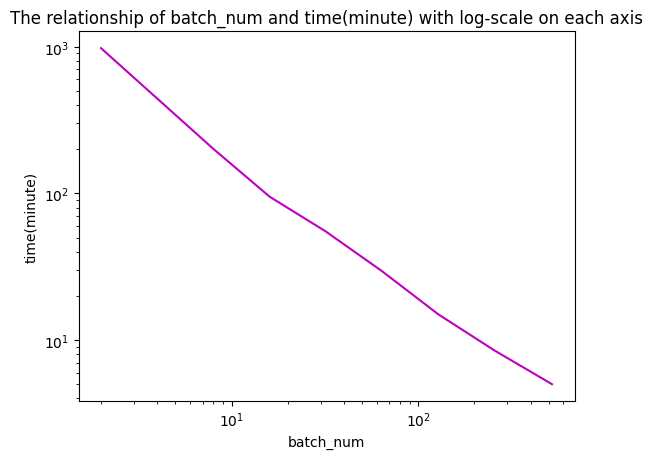

In [21]:
plt.figure()
plt.plot(batch_num,time,"-m")
plt.xlabel("batch_num")
plt.ylabel("time(minute)")
plt.xscale("log")
plt.yscale("log")
plt.title("The relationship of batch_num and time(minute) with log-scale on each axis")

## Train my final model

In [10]:
BATCH_SIZE = 128
embedding_size = 50 
learning_rate = 0.00005
window = 2
min_token_freq = 5
epochs = 2
model = Word2Vec(len(corpus.word_to_index), embedding_size)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [11]:
dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
len(dataloader)

46852

In [13]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here


# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take
writer = SummaryWriter()

count = 0

loss_sum = 0

for epoch in range(epochs):
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader)):

        # NOTE: since you created the data as a tuple of three np.array instances,
        # these have now been converted to Tensor objects for us
        target_ids, context_ids, labels = data    
    
        
        # TODO: Fill in all the training details here
        
        y_predicted = model(target_ids,context_ids)
            
        loss = criterion(torch.stack(y_predicted), torch.stack(labels).float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 

        count = count + 1

        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it. 
        
        if (count+1)%100 == 0:
            writer.add_scalar("Loss/step", loss_sum, count+1)
            loss_sum = 0
        if count >= 54000:
            break
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model.eval()

 15%|█▌        | 7147/46852 [02:04<11:29, 57.61it/s]


Word2Vec(
  (target_embeddings): Embedding(29171, 50)
  (context_embeddings): Embedding(50, 29171)
)

In [14]:
writer.flush()

## Verify things are working

Once you have an initial model trained, try using the following code to query the model for what are the nearest neighbor of a word. This code is intended to help you debug

In [15]:
def get_neighbors(model, word_to_index, target_word):
    """ 
    Finds the top 10 most similar words to a target word
    """
    outputs = []
    for word, index in tqdm(word_to_index.items(), total=len(word_to_index)):
        similarity = compute_cosine_similarity(model, word_to_index, target_word, word)
        result = {"word": word, "score": similarity}
        outputs.append(result)

    # Sort by highest scores
    neighbors = sorted(outputs, key=lambda o: o['score'], reverse=True)
    return neighbors[1:11]

def compute_cosine_similarity(model, word_to_index, word_one, word_two):
    '''
    Computes the cosine similarity between the two words
    '''
    try:
        word_one_index = word_to_index[word_one]
        word_two_index = word_to_index[word_two]
    except KeyError:
        return 0

    embedding_one = model.target_embeddings(torch.LongTensor([word_one_index]))
    embedding_two = model.target_embeddings(torch.LongTensor([word_two_index]))
    similarity = 1 - abs(float(cosine(embedding_one.detach().squeeze().numpy(),
                                      embedding_two.detach().squeeze().numpy())))
    return similarity

In [16]:
get_neighbors(model, corpus.word_to_index, "recommend")

100%|██████████| 29171/29171 [00:01<00:00, 27863.90it/s]


[{'word': 'give', 'score': 0.9997545480728149},
 {'word': 'able', 'score': 0.9997357726097107},
 {'word': 'stop', 'score': 0.9997191429138184},
 {'word': 'll', 'score': 0.9997152090072632},
 {'word': 'help', 'score': 0.9997101426124573},
 {'word': 'pay', 'score': 0.9997094869613647},
 {'word': 'go', 'score': 0.999708890914917},
 {'word': 'already', 'score': 0.9997056722640991},
 {'word': 'imagine', 'score': 0.999700129032135},
 {'word': 'take', 'score': 0.9997000098228455}]

In [17]:
get_neighbors(model, corpus.word_to_index, "son")

100%|██████████| 29171/29171 [00:01<00:00, 27835.43it/s]


[{'word': '12', 'score': 0.9999976754188538},
 {'word': '8', 'score': 0.9999968409538269},
 {'word': '9', 'score': 0.9999963045120239},
 {'word': '6', 'score': 0.9999957084655762},
 {'word': 'daughter', 'score': 0.9999951124191284},
 {'word': 'months', 'score': 0.9999949932098389},
 {'word': '11', 'score': 0.9999949336051941},
 {'word': 'advanced', 'score': 0.999994695186615},
 {'word': 'nora', 'score': 0.999994695186615},
 {'word': 'children', 'score': 0.9999944567680359}]

# Save your vectors for the gensim inspection part!

Once you have a fully trained model, save it using the code below. Note that we only save the `target_embeddings` from the model, but you could modify the code if you want to save the context vectors--or even try doing fancier things like saving the concatenation of the two or the average of the two!

In [18]:
def save(model, corpus, filename):
    '''
    Saves the model to the specified filename as a gensim KeyedVectors in the
    text format so you can load it separately.
    '''
    
    # Creates an empty KeyedVectors with our embedding size
    kv = KeyedVectors(vector_size=model.embedding_size)        
    vectors = []
    words = []
    # Get the list of words/vectors in a consistent order
    for index in trange(model.target_embeddings.num_embeddings):
        word = corpus.index_to_word[index]
        vectors.append(model.target_embeddings(torch.LongTensor([index])).detach().numpy()[0])
        words.append(word)

    # Fills the KV object with our data in the right order
    kv.add_vectors(words, vectors) 
    kv.save_word2vec_format(filename, binary=False)
    
    return kv


# Save your vectors / data for the pytorch classifier in Part 4!

We'll be to using these vectors later in Part 4. We want to save them in a format that PyTorch can easily use. In particular you'll need to save the _state dict_ of the embeddings, which captures all of its information. 

In [19]:
output_part4 = save(model, corpus, 'reviews-word2vec.med.txt')

  0%|          | 0/29171 [00:00<?, ?it/s]

We will also need the mapping from word to index so we can figure out which embedding to use for different words. Save the `corpus` objects mapping to a file using your preferred format (e.g., pickle or json).

In [20]:
output_part4

Pick 10 target words and compute the most similar for each using Gensim’s function.

In [274]:
output_part4.similar_by_word("book")[0][0]

'novel'

In [275]:
output_part4.similar_by_word("need")[0][0]

'believe'

In [273]:
output_part4.similar_by_word("see")[0][0]

'understand'

In [276]:
output_part4.similar_by_word("provide")[0][0]

'ask'

In [277]:
output_part4.similar_by_word("cute")[0][0]

'fascinating'

In [295]:
output_part4.similar_by_word("inexcusable")[0][0]

'terrorists'

In [278]:
output_part4.similar_by_word("generation")[0][0]

'survivor'

In [279]:
output_part4.similar_by_word("letter")[0][0]

'alphabet'

In [290]:
output_part4.similar_by_word("decent")[0][0]

'fascinating'

In [294]:
output_part4.similar_by_word("study")[0][0]

'master'

Given the analogy function, find five interesting word analogies with your word2vec model.

In [362]:
output_part4.most_similar(positive=['like', 'dislike'], negative=['love'])[0][0]

'why'

In [363]:
output_part4.most_similar(positive=['mike', '1'], negative=['tom'])[0][0]

'5'

In [364]:
output_part4.most_similar(positive=['pencil', 'write'], negative=['brush'])[0][0]

'come'

In [365]:
output_part4.most_similar(positive=['ear', 'hear'], negative=['mouth'])[0][0]

'ask'

In [366]:
output_part4.most_similar(positive=['people', 'novel'], negative=['persons'])[0][0]

'ideas'

# SI 630: Homework 2 Part 4: Attention-based classification

This last part of homework 2 will have you _using_ the vectors we learned from your word2vec implementation to do classification. You should complete the initial word2vec part before before starting on this.

Broadly, this last part of the homework consists of a few major steps:
1. Load in the data, word vectors, and word-indexing
2. Define the attention-based classification network
3. Train your model at least one epoch (2+ is recommended though).
4. Perform exploratory analyses on attention
5. Test the effects of freezing the pre-trained word vectors (see homework PDF for details)

After Step 2, you should be able to train your classifier implementation on a small percent of the dataset and verify that it's learning correctly. **Please note that this list is a general sketch and the homework PDF has the full list/description of to-dos and all your deliverables.**


### Estimated performance times

We designed this homework to be run on a laptop-grade CPU, so no GPU is required. If your primary computing device is a tablet or similar device, this homework can also be _developed_ on that device but then run on a more powerful machine in the Great Lakes cluster (for free). Such cases are the exception though. Following, we report on the estimated times from our reference implementation for longer-running or data-intensive pieces of the homework. Your timing may vary based on implementation design; major differences in time (e.g., 10x longer) usually point to a performance bug.

* Reading data, tokenizing, and converting to ids: ~20 seconds
* Training one epoch: ~18 minutes
* Training one epoch using frozen embeddings: ~3 minutes
* Evaluating on dev/test set: ~5 seconds

In [72]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

np.random.seed(42)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from collections import Counter
import random
from torch import optim

import pandas as pd
import pickle

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib
from sklearn.metrics import f1_score
import seaborn as sns

# Sort of smart tokenization
from nltk.tokenize import RegexpTokenizer

# Attention plotting
import matplotlib.pyplot as plt

In [73]:
# Load the word-to-index mapping we used for word2vec and use the same type
# of tokenizer. We'll need to use this to tokenize in the same way and keep 
# the same word-to-id mapping

tokenizer = corpus.tokenize
word_to_index = corpus.word_to_index
index_to_word = corpus.index_to_word

# Load in the datasets 

You can keep these as pandas data frames.

In [74]:
sent_train_df = pd.read_csv("sentiment.train.csv")
sent_dev_df = pd.read_csv("sentiment.dev.csv")
sent_test_df = pd.read_csv("sentiment.test.csv")
train_list = []
dev_list = []
test_list = []

Convert each dataset into a list of tuples of the form `([word-ids,...], label)`. Both the word ids and the label should be numpy arrays so they will get converted into Tensors by our data loader. Note that you did something very similar for creating the word2vec training data. This process will require tokenizing the data in the same way as you did for word2vec and using the same word-to-id mapping (both of which you loaded/created above).

In [75]:
def get_part4_list(df_part4,list_part4):
    for index, row in df_part4.iterrows():
        txt = tokenizer(row['text'].lower())
        txt_list = []
        for i in txt:
            if i in word_to_index:
                txt_list.append(word_to_index[i])
            else:
                txt_list.append(word_to_index["<UNK>"])
        list_part4.append((txt_list,row['label']))
    return list_part4

In [76]:
train_list = get_part4_list(sent_train_df,train_list)
dev_list = get_part4_list(sent_dev_df,dev_list)

If this worked you should see XXXX train, XXXX dev, and XXX test instances.

In [77]:
len(train_list), len(dev_list)

(160000, 20000)

# Define the Classifier Model

Just like we did for word2vec, let's define a PyTorch `nn.Module` class here that will contain our classifier.

In [78]:
class DocumentAttentionClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.embeddings_fname = embeddings_fname
        
        self.word2vec_para = model.target_embeddings.weight
  
        self.v_attention = nn.Embedding(self.num_heads, self.embedding_size)
        
        self.linear = torch.nn.Linear(self.num_heads*self.embedding_size,1)
        
    

    def forward(self, word_ids):
        
        soft_list = []
        for i in range(self.num_heads):
                soft_each = []
                for j in range(len(word_ids)):
                        dott = torch.dot(self.word2vec_para[word_ids[j][0]],self.v_attention.weight[i])
                        soft_each.append(dott)
                soft_list.append(soft_each)
                                
        a_list = []
        c_list = []
        for i in range(self.num_heads):
                d = 0
                c = torch.softmax(torch.tensor(soft_list[i]),dim=0)
                d = (torch.unsqueeze(c, 1)*self.word2vec_para[[word_ids]]).sum(axis=0)
                c_list.append(c)
                a_list.append(d)
        
        result = torch.cat([i for i in a_list], dim=0)
        
        y_predicted=torch.sigmoid(self.linear(result))
        
        return y_predicted, torch.stack(c_list).T

# Build the code training loop

We'll evaluate periodically so before we start training, let's define a function that takes in some evaluation data (e.g., the dev or test sets) and computes the F1 score on that data. 

In [79]:
list_dev_label = []
for i in range(len(dev_list)):
    list_dev_label.append(dev_list[i][1])

In [80]:
len(list_dev_label)

20000

In [81]:
def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    with torch.no_grad():
        true_positive = 0
        false_positive = 0
        false_negative = 0
        list_dev_predict = []
        
        for step, data in enumerate(eval_data):
            word_ids, label = data   
            y_predicted_2,  v_matrix_2 = model(word_ids)
            y_predicted_cls = y_predicted_2.round() 
            list_dev_predict.append(y_predicted_cls)
        
        for i in range(len(list_dev_predict)):
            if list_dev_label[i] == 1 and list_dev_predict[i] == 1:
                true_positive = true_positive+1
            elif list_dev_label[i] == 0 and list_dev_predict[i] == 1:
                false_positive = false_positive + 1
            elif list_dev_label[i] == 1 and list_dev_predict[i] == 0:
                false_negative = false_negative+1
        if true_positive+false_positive == 0 or true_positive+false_negative == 0:
            return 0
        else:
            Precision = true_positive/(true_positive+false_positive)
            Recall = true_positive/(true_positive+false_negative)
            if Precision+Recall == 0:
                return 0
            else: 
                F1_Score = 2 * (Precision * Recall) / (Precision + Recall)
                return F1_Score

Now that you have data in the right format and a neural network designed, it's time to train the network and see if it's all working. The training code will look surprisingly similar to your word2vec code. 

For all steps, be sure to use the hyperparameters values described in the write-up.

1. Initialize your optimizer and loss function 
2. Create your network
3. Load your dataset into PyTorch's `DataLoader` class, which will take care of batching and shuffling for us (yay!)
4. **see below:** Create a new `SummaryWriter` to periodically write our running-sum of the loss to a tensorboard
5. Train your model 

For step 4, in addition to writing the loss, you should write the F1 score on the dev set to the writer as well, using the specified number of steps.

**NOTE:** In this training, you'll use a batch size of 1, which will make your life _much_ simpler.

In [204]:
epochs2 = 2
learning_rate2 = 0.00005
model2 = DocumentAttentionClassifier(len(corpus.word_to_index), embedding_size, 4, "reviews-word2vec.med.txt")
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate2)

In [205]:
dataloader2 = DataLoader(train_list, batch_size=1, shuffle=False)

In [206]:
dataloader3 = DataLoader(dev_list, batch_size=1, shuffle=False)

In [207]:
run_eval(model2,dataloader3)

0.6662220740246748

In [208]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here

writer = SummaryWriter()

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

count = 0

loss_sum = 0

for epoch in range(epochs2):
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader2)):

        # NOTE: since you created the data np.array instances,
        # these have now been converted to Tensor objects for us
        word_ids, label = data    
        
        # TODO: Fill in all the training details here
        y_predicted, v_matrix = model2(word_ids)
            
        loss = criterion(y_predicted, label.float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
        
        count = count + 1
        
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        if (count+1)%500 == 0:
            writer.add_scalar("Loss/step", loss_sum, count+1)
            loss_sum = 0
        
        if (count+1)%5000 == 0:
            F1_Score = run_eval(model2,dataloader3)
            writer.add_scalar("F1_Score/step", F1_Score, count+1)
            
        if count >= 180000:
            break
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model2.eval()

 12%|█▏        | 19999/160000 [03:33<24:52, 93.79it/s]   


DocumentAttentionClassifier(
  (v_attention): Embedding(4, 50)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [193]:
writer.flush()

# Inspecting what the model learned

In this last bit of the homework you should look at the model's attention weights. We've written a visualization helper function below that will plot the attention weights. You'll need to fill in the `get_label_and_weights` method that uses the model to classify some new text and structures the attention output in a way that's specified. 

**NOTE:** most of the code for `get_label_and_weights` is code you've already written above.

In [194]:
def get_label_and_weights(text):
    '''
    Classifies the text (requires tokenizing, etc.) and returns (1) the classification label, 
    (2) the tokenized words in the model's vocabulary, 
    and (3) the attention weights over the in-vocab tokens as a numpy array. Note that the
    attention weights will be a matrix, depending on how many heads were used in training.
    '''
    with torch.no_grad():
        txt = tokenizer(text.lower())
        txt_list = []
        txt_word = []
        for i in txt:
            txt_word.append(i)
            if i in word_to_index:
                txt_list.append(word_to_index[i])
            else:
                txt_list.append(word_to_index["<UNK>"])
                
        dataloader_txt = DataLoader(list(txt_list), batch_size=1, shuffle=False)
        
        list_txt = []
        
        for step, data in enumerate(dataloader_txt):
            list_txt.append(data)
            
        predict_value, v_matrix = model2(list_txt)
        
        return predict_value, txt_word, v_matrix
        

### Helper functions for visualization

In [195]:
def visualize_attention(words, attention_weights):
    '''
    Makes a heatmap figure that visualizes the attention weights for an item.
    Attention weights should be a numpy array that has the shape (num_words, num_heads)
    '''
    fig, ax = plt.subplots() 
    # Rescale image size based on the input length
    fig.set_size_inches((len(words), 4))    
    im = ax.imshow(attention_weights.T)

    head_labels = [ 'head-%d' % h for h in range(attention_weights.shape[1])]
    ax.set_xticks(np.arange(len(words))) # , labels=words)
    ax.set_yticks(np.arange(len(head_labels))) #, labels=head_labels)

    # Rotate the word labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Add the words and axis labels
    ax.set_yticklabels(labels=range(attention_weights.shape[1]), fontsize=16)
    ax.set_ylabel('Attention Head', fontsize=16)
    ax.set_xticklabels(labels=words, fontsize=16)

    # Add a color bar to show probability scaling
    cb = fig.colorbar(im, ax=ax, label='Probability', pad = 0.01)
    cb.ax.tick_params(labelsize=16)
    cb.set_label(label='Probability',size=16)
    fig.tight_layout()
    plt.show()

Example messages to try visualizing.

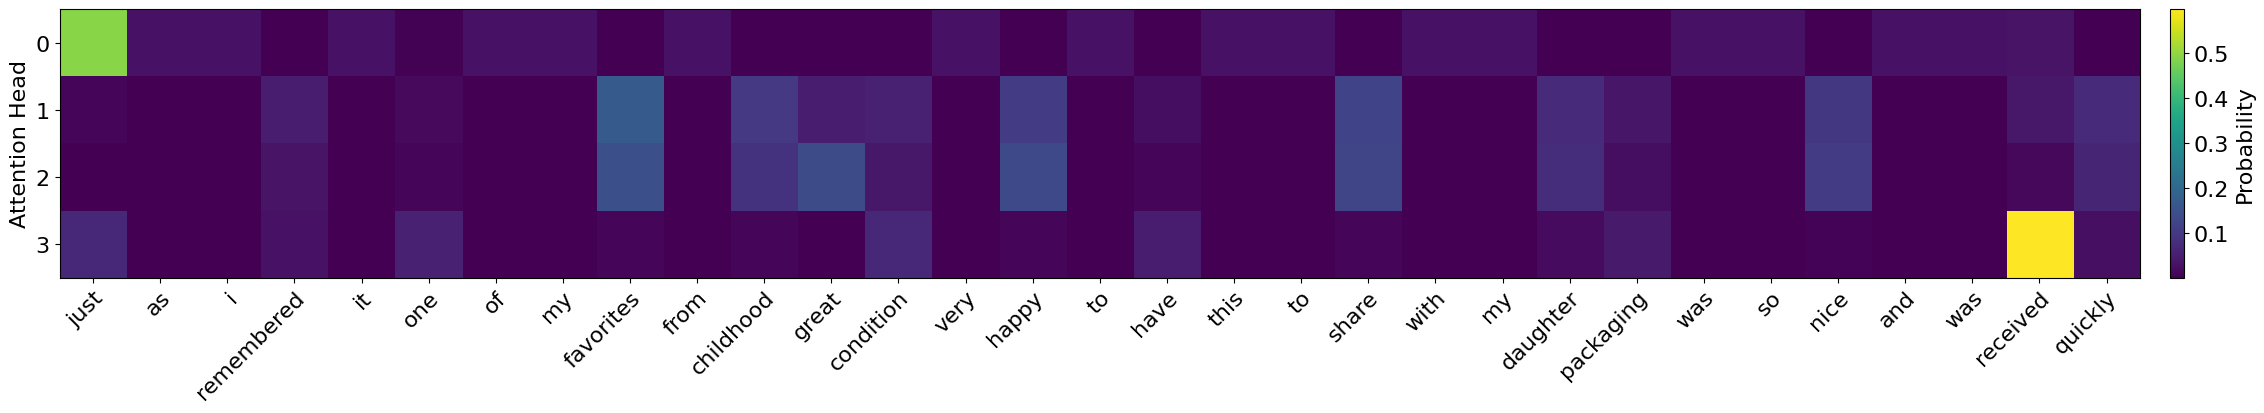

In [238]:
s = 'Just as I remembered it, one of my favorites from childhood! Great condition, very happy to have this to share with my daughter. Packaging was so nice and was received quickly.'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

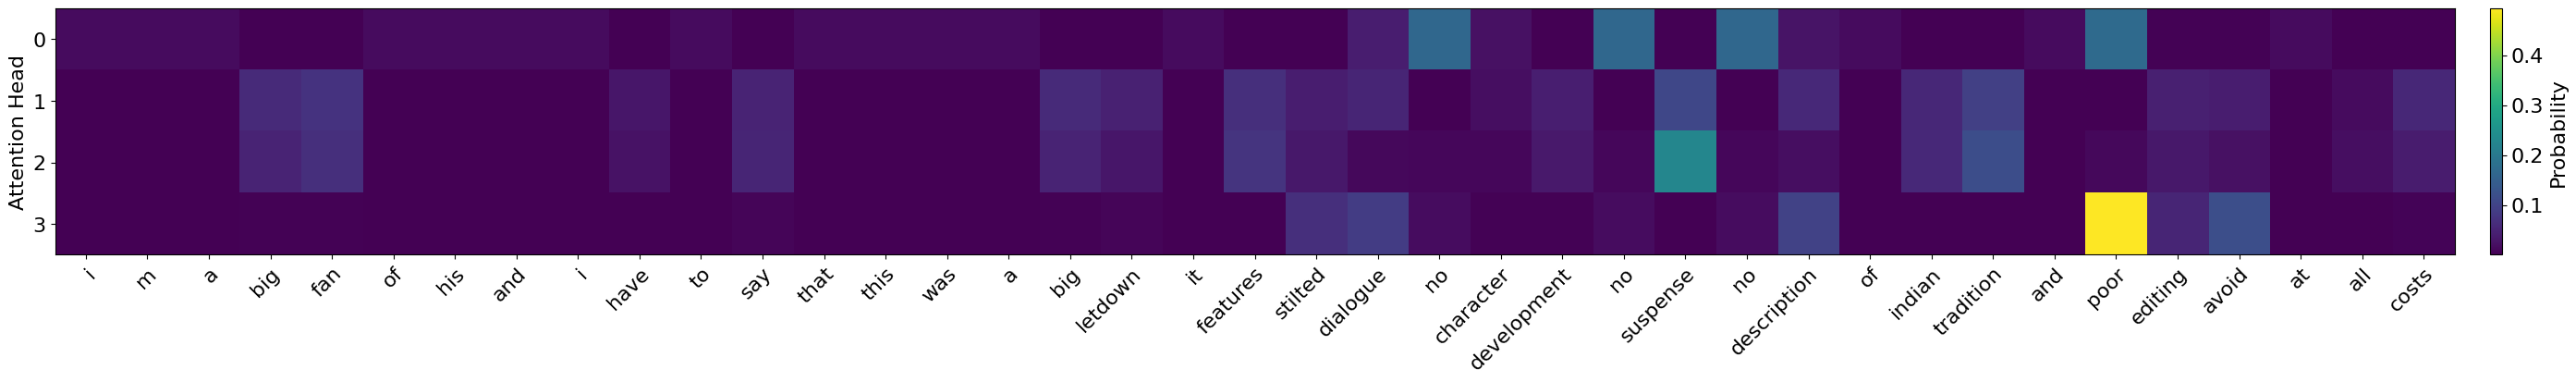

In [210]:
s = '''
I'm a big fan of his, and I have to say that this was a BIG letdown. It features: Stilted dialogue, no character development, no suspense, no description of Indian tradition and poor editing.\n\nAvoid at all costs.
'''
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

1.	Generate at least four “interesting” attention plots from text in the dev data, at least two for each class, and describe why you think the plots are interesting.

In [214]:
# I will use this function to find the mistakes in the dev prediction.
def get_run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    with torch.no_grad():
        true_positive = 0
        false_positive = 0
        false_negative = 0
        list_dev_predict = []
        
        for step, data in enumerate(eval_data):
            word_ids, label = data   
            y_predicted_2,  v_matrix_2 = model(word_ids)
            y_predicted_cls = y_predicted_2.round() 
            list_dev_predict.append(y_predicted_cls)
        
        return list_dev_predict

In [215]:
list_dev_predict = get_run_eval(model2,dataloader3)

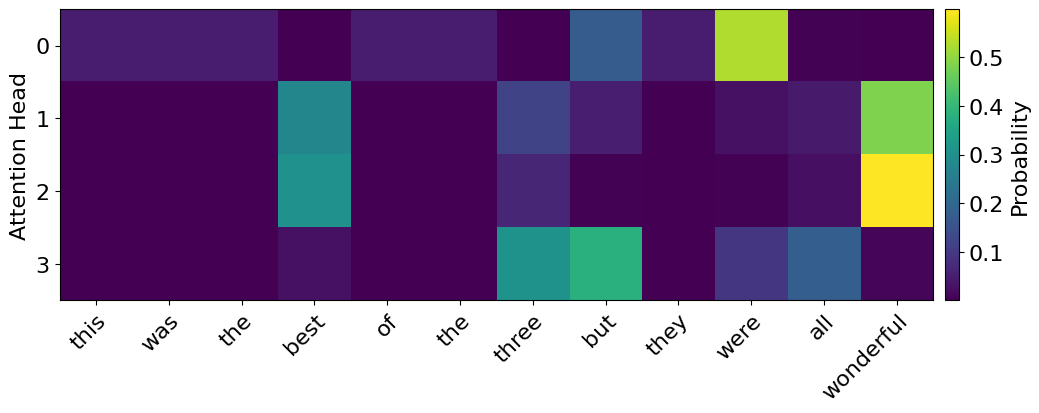

In [246]:
s = "This was the best of the three but they were all wonderful"
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

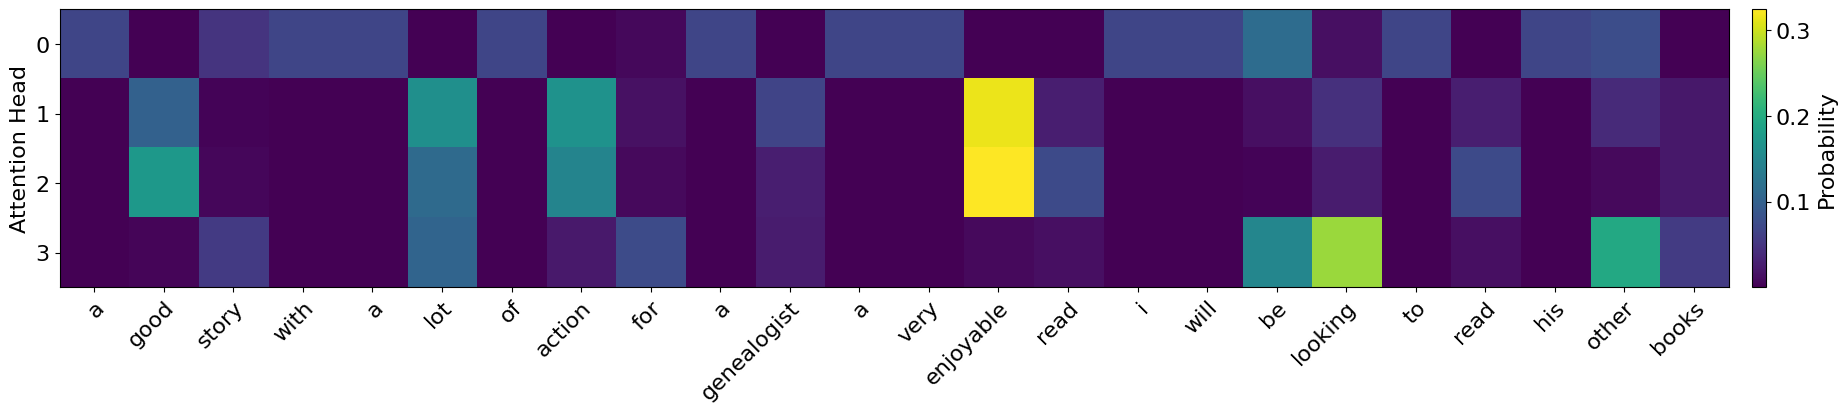

In [212]:
s = 'A good story with a lot of action......for a genealogist a very enjoyable read. I will be looking to read his other books'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

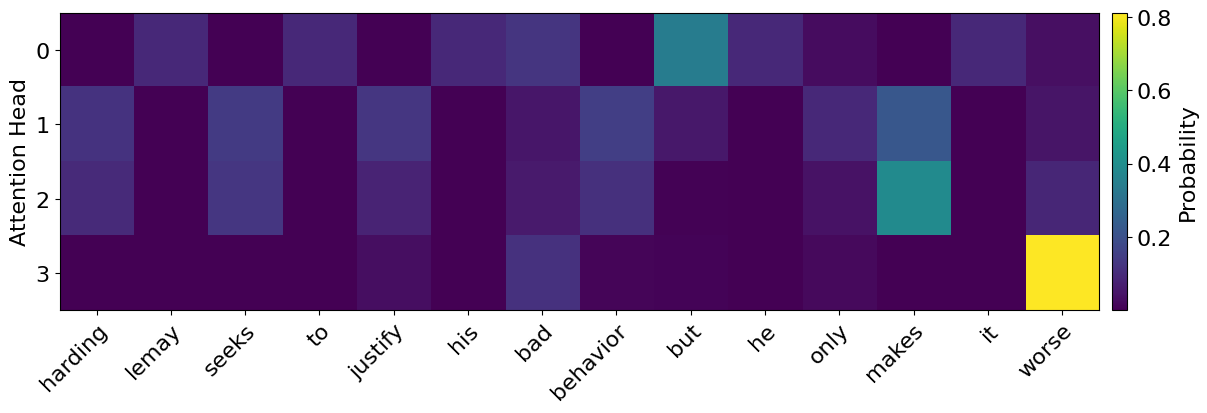

In [224]:
s = "Harding Lemay seeks to justify his bad behavior, but he only makes it worse."
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

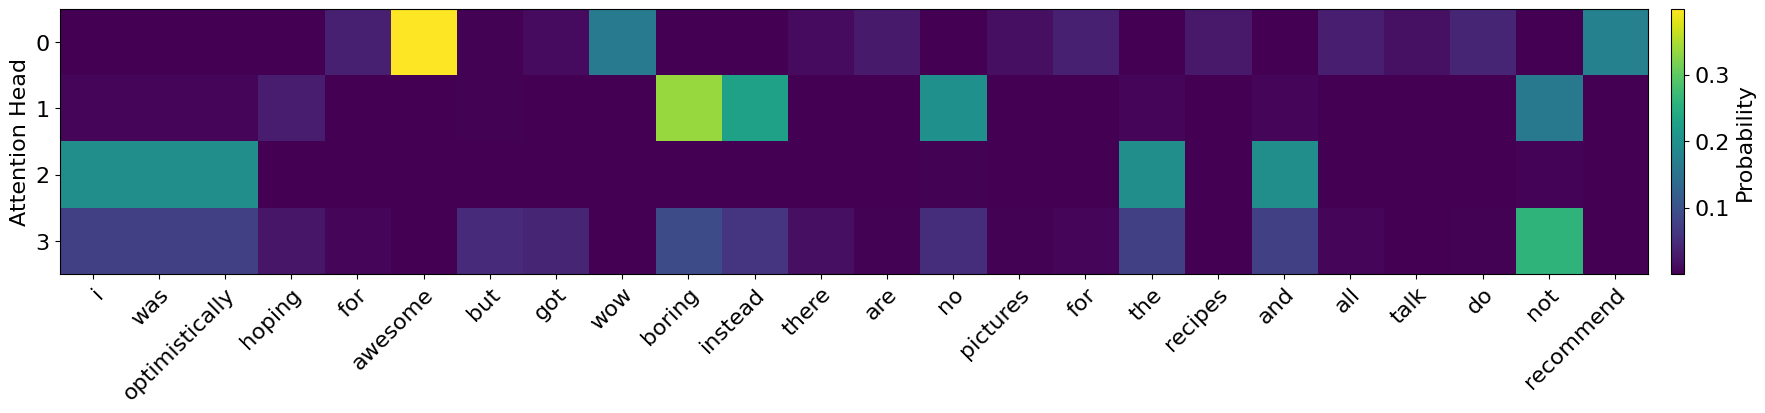

In [203]:
s = "I was optimistically hoping for awesome but got wow boring instead. There are no pictures for the recipes and all talk. Do not recommend"
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

2.	Using what you’ve observed from the visualizations, write a short paragraph describing what you think the attention heads are looking for.

The attentions are looking for the most emotional words, generally adjectives; In addition, if the sentence contains negative words or turning words, the attention will pay more attention to these words. Therefore, when the sentence contains the negative words or turning words, it is more likely to get 0, however, when it just has the positive words, it will give 1.

3.	Try to fool the classifier by either writing an example that the model predicts incorrectly or directly looking for a mistake on the dev data.

In [250]:
for i in range(len(list_dev_predict)):
    if list_dev_predict[i] != list_dev_label[i]:
        print(i)

16
18
25
30
53
60
74
77
83
94
97
98
101
102
103
105
110
117
133
143
144
167
171
179
185
197
201
205
217
224
227
236
248
251
267
276
292
293
297
301
315
316
337
364
376
377
388
405
417
436
438
442
448
452
463
471
484
487
495
511
516
523
537
544
546
566
581
595
602
617
619
625
629
630
642
643
648
650
658
660
668
672
678
680
682
693
694
701
705
707
712
714
721
728
732
735
744
756
761
799
801
802
806
808
826
836
837
849
858
871
879
904
906
908
914
921
926
938
960
971
1001
1005
1007
1009
1010
1014
1024
1045
1055
1070
1093
1096
1103
1112
1115
1116
1117
1124
1126
1137
1145
1158
1177
1188
1194
1195
1196
1202
1213
1214
1219
1230
1231
1234
1250
1255
1256
1265
1267
1308
1316
1319
1322
1324
1342
1358
1369
1371
1374
1381
1384
1389
1395
1396
1455
1459
1469
1477
1497
1502
1510
1513
1517
1529
1530
1535
1560
1567
1586
1590
1593
1625
1679
1683
1691
1696
1698
1709
1712
1714
1719
1737
1746
1754
1761
1767
1783
1789
1798
1809
1811
1830
1832
1843
1864
1868
1884
1886
1893
1898
1906
1922
1930
1931
1938
1939
19

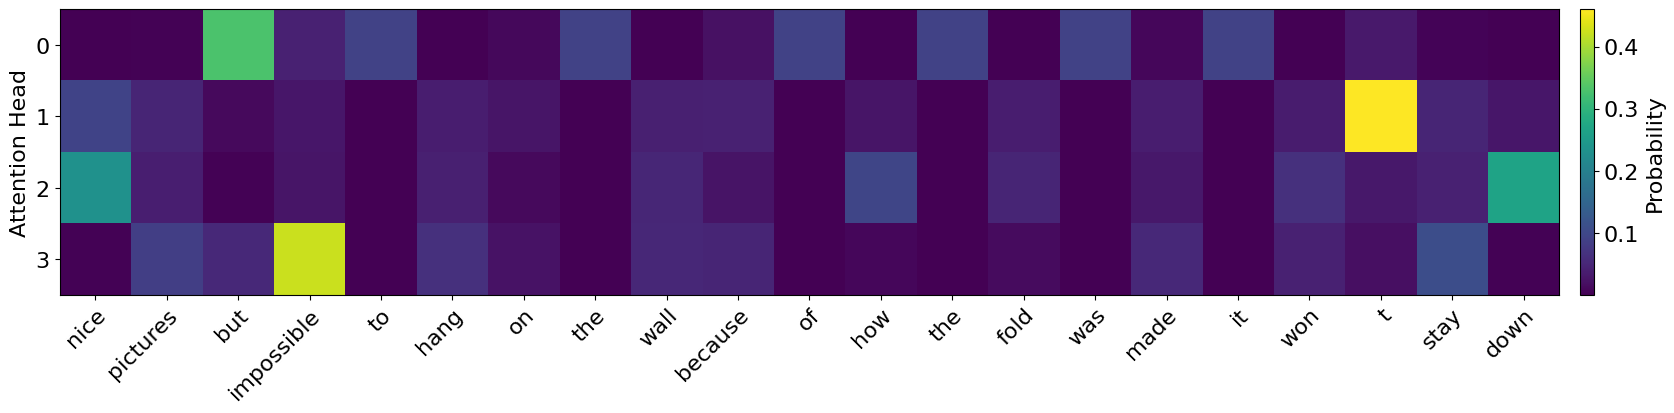

In [247]:
# I use 60 to plot the figure, which I find the text in the dev file.
s = "Nice pictures but impossible to hang on the wall because of how the fold was made. It won't stay down."
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

### For the test_list part

In [102]:
test_list 

[]

In [103]:
sent_test_df.head()

,inst_id,text
0,0,Really sad review as I absolutely loved the fi...
1,1,"Excellent content, perfect for Christians who ..."
2,2,This is an okay book if you need advice on bud...
3,3,This is one book you can't put down! This book...
4,4,There were to many names that I had no idenity...


In [104]:
for index, row in sent_test_df.iterrows():
    txt = tokenizer(row['text'].lower())
    txt_list = []
    for i in txt:
        if i in word_to_index:
            txt_list.append(word_to_index[i])
        else:
            txt_list.append(word_to_index["<UNK>"])
    test_list.append(txt_list)

In [105]:
dataloader_test = DataLoader(list(test_list), batch_size=1, shuffle=False)

predict_value_list = []

for step, data in enumerate(dataloader_test):
    predict_value, v_matrix = model2(data)
    if predict_value < 0.5:
        label_value = 0
    else:
        label_value = 1
    predict_value_list.append(label_value)


In [106]:
df = pd.DataFrame(predict_value_list,columns=["prediction"])
df.index.name="inst_id"
df.to_csv('part3_predict.csv')

## Try Freeze

In [256]:
freeze_attention = nn.Embedding(4, embedding_size)

In [258]:
freeze_attention.weight

Parameter containing:
tensor([[ 1.0311e+00,  1.2598e+00,  1.6876e+00, -1.2526e+00,  2.8414e-02,
         -1.0142e+00,  1.0823e-01, -2.0076e+00, -1.7497e-01,  7.6419e-01,
         -8.4372e-03, -1.6659e-01,  6.9057e-01,  1.0719e-03, -2.5757e+00,
          6.8383e-01,  1.2380e+00,  8.0618e-01, -4.1841e-01,  4.9101e-01,
         -4.0135e-01, -5.4321e-01, -9.5959e-01,  7.5052e-01,  6.0678e-01,
         -1.6478e+00,  2.0706e+00,  1.0779e+00,  6.4623e-01,  2.5097e-02,
         -1.7135e+00,  1.5853e-01, -1.2727e-01,  2.2072e-01, -4.8668e-01,
         -9.5713e-01, -1.4003e+00, -1.6928e-01, -3.3122e-01, -7.5661e-01,
         -3.0446e-01, -1.5840e+00,  9.7017e-01,  7.1549e-01,  1.3013e+00,
         -2.9996e-01,  6.8044e-01, -3.5465e-01, -1.9498e-01, -1.1864e+00],
        [ 5.9016e-01,  1.7568e+00, -2.6736e-01, -1.3918e+00, -5.4812e-01,
          8.9395e-01,  5.0591e-01, -4.0467e-02,  1.0360e+00,  4.9131e-01,
          3.0447e-01, -1.4496e+00, -6.1208e-01, -1.0813e+00, -6.7908e-01,
          9.366

In [259]:
class DocumentAttentionClassifier_freeze(nn.Module):
    
    def __init__(self, vocab_size, embedding_size, num_heads, embeddings_fname):
        '''
        Creates the new classifier model. embeddings_fname is a string containing the
        filename with the saved pytorch parameters (the state dict) for the Embedding
        object that should be used to initialize this class's word Embedding parameters
        '''
        super(DocumentAttentionClassifier_freeze, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_heads = num_heads
        self.embeddings_fname = embeddings_fname
        
        self.word2vec_para = model.target_embeddings.weight
        
        self.linear = torch.nn.Linear(self.num_heads*self.embedding_size,1)
        
    

    def forward(self, word_ids):
        
        soft_list = []
        for i in range(self.num_heads):
                soft_each = []
                for j in range(len(word_ids)):
                        dott = torch.dot(self.word2vec_para[word_ids[j][0]],freeze_attention.weight[i])
                        soft_each.append(dott)
                soft_list.append(soft_each)
                                
        a_list = []
        c_list = []
        for i in range(self.num_heads):
                d = 0
                c = torch.softmax(torch.tensor(soft_list[i]),dim=0)
                d = (torch.unsqueeze(c, 1)*self.word2vec_para[[word_ids]]).sum(axis=0)
                c_list.append(c)
                a_list.append(d)
        
        result = torch.cat([i for i in a_list], dim=0)
        
        y_predicted=torch.sigmoid(self.linear(result))
        
        return y_predicted, torch.stack(c_list).T

In [260]:
epochs2 = 1
learning_rate2 = 0.00005
model_freeze = DocumentAttentionClassifier_freeze(len(corpus.word_to_index), embedding_size, 4, "reviews-word2vec.med.txt")
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model_freeze.parameters(), lr=learning_rate2)

In [261]:
# TODO: Set your training stuff, hyperparameters, models, tensorboard writer etc. here

writer = SummaryWriter()

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take

for epoch in range(epochs2):

    loss_sum = 0
    
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(tqdm(dataloader2)):

        # NOTE: since you created the data np.array instances,
        # these have now been converted to Tensor objects for us
        word_ids, label = data    
        
        # TODO: Fill in all the training details here
        y_predicted, v_matrix = model_freeze(word_ids)
            
        loss = criterion(y_predicted, label.float())

        loss_sum = loss_sum + loss.item()
    
        optimizer.zero_grad()

        loss.backward() 

        optimizer.step() 
        
        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to tensorboard. Be sure
        # to reset the running sum after reporting it.
        if (step*(epoch+1)+1)%500 == 0:
            writer.add_scalar("Loss/step", loss_sum, step*(epoch+1)+1)
            loss_sum = 0
        
        if (step*(epoch+1)+1)%5000 == 0:
            F1_Score = run_eval(model_freeze,dataloader3)
            writer.add_scalar("F1_Score/step", F1_Score, step*(epoch+1)+1)
            
            
        
        # TODO: it can be helpful to add some early stopping here after
        # a fixed number of steps (e.g., if step > max_steps)
        
        

# once you finish training, it's good practice to switch to eval.
model_freeze.eval()

100%|██████████| 160000/160000 [26:26<00:00, 100.84it/s] 


DocumentAttentionClassifier_freeze(
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

In [262]:
freeze_attention.weight

Parameter containing:
tensor([[ 1.0311e+00,  1.2598e+00,  1.6876e+00, -1.2526e+00,  2.8414e-02,
         -1.0142e+00,  1.0823e-01, -2.0076e+00, -1.7497e-01,  7.6419e-01,
         -8.4372e-03, -1.6659e-01,  6.9057e-01,  1.0719e-03, -2.5757e+00,
          6.8383e-01,  1.2380e+00,  8.0618e-01, -4.1841e-01,  4.9101e-01,
         -4.0135e-01, -5.4321e-01, -9.5959e-01,  7.5052e-01,  6.0678e-01,
         -1.6478e+00,  2.0706e+00,  1.0779e+00,  6.4623e-01,  2.5097e-02,
         -1.7135e+00,  1.5853e-01, -1.2727e-01,  2.2072e-01, -4.8668e-01,
         -9.5713e-01, -1.4003e+00, -1.6928e-01, -3.3122e-01, -7.5661e-01,
         -3.0446e-01, -1.5840e+00,  9.7017e-01,  7.1549e-01,  1.3013e+00,
         -2.9996e-01,  6.8044e-01, -3.5465e-01, -1.9498e-01, -1.1864e+00],
        [ 5.9016e-01,  1.7568e+00, -2.6736e-01, -1.3918e+00, -5.4812e-01,
          8.9395e-01,  5.0591e-01, -4.0467e-02,  1.0360e+00,  4.9131e-01,
          3.0447e-01, -1.4496e+00, -6.1208e-01, -1.0813e+00, -6.7908e-01,
          9.366